# Positional embeddings for sequences

## Sequence embeddings

In [39]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np

First let's define the positional encodings as used in the Attention Is All You Need (AIAYN) paper.
https://arxiv.org/abs/1706.03762

$$PE_{(pos, 2i)} = \sin\left(pos / 10000^{2i\ /\ d_{model}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(pos / 10000^{2i\ /\ d_{model}}\right)$$

The base model uses 512 dimensional representations, so we'll stick with that in this notebook.

In [40]:
def pe_sin(pos, i, d):
    return math.sin(pos / math.pow(10000, 2.0 * i / d))

def pe_cos(pos, i, d):
    return math.cos(pos / math.pow(10000, 2.0 * i / d)) 
def pe(pos, d):
    vec = []
    for i in range(d / 2):
        vec.append(pe_sin(pos, i, d))
        vec.append(pe_cos(pos, i, d))
    return vec

Let's look at a 30 word sentence, to start.

In [41]:
pe_30 = np.array([pe(pos, 512) for pos in range(30)])
a = np.dot(pe_30, pe_30.T)
print(np.min(a))
print(np.max(a))

144.937566242
256.0


The highest frequency components may cycle multiple times within the span of those 30 words.

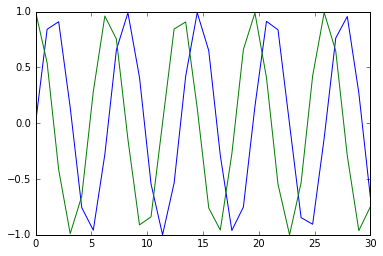

In [226]:
x = np.linspace(0, 30, 30)
plt.plot(x, [pe_30[i,0] for i in range(30)])
plt.plot(x, [pe_30[i,1] for i in range(30)])
plt.show()

Low frequency components will be fixed for all but the longest sentences.

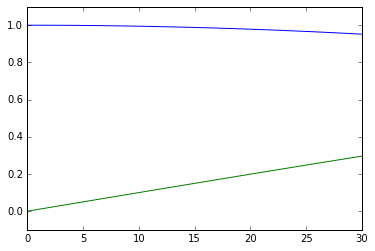

In [338]:
plt.plot(x, [pe_30[i, 253] for i in range(30)])
plt.plot(x, [pe_30[i, 254] for i in range(30)])
plt.ylim([-0.1, 1.1])
plt.show()

For the purposes of attention, we'll run softmax over query and key dot products.

Here's softmax:

In [280]:
def softmax(x):
    x = x.T
    maxes = x.max(axis=0)
    x_rel = x - maxes
    e_x = np.exp(x_rel)
    Zs = np.sum(e_x, axis=0)
    p = e_x / Zs
    return p.T

It's interesting to look at the raw values after dot product (and division by $\sqrt{d_k}$):

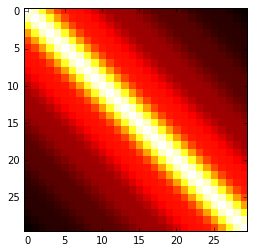

In [281]:
plt.imshow(a / math.sqrt(512), cmap='hot', interpolation='nearest')
plt.show()

Applying softmax sharpens this distribution. We can pretty accurately address a position using these sinusoidal attention values:

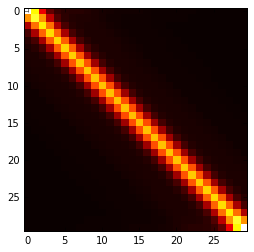

In [282]:
plt.imshow(softmax(a / math.sqrt(512)), cmap='hot', interpolation='nearest')
plt.show()

The AIAYN paper defines

$$\textrm{Attention}(Q, K, V) = \textrm{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

$$\textrm{MultiHead}(Q, K, V) = \textrm{Concat}(\textrm{head}_1,\ldots,\textrm{head}_h)W^O$$

$$\textrm{head}_{i} = \textrm{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

One linear transform is applied to the query, and another is applied to the keys.
Conventional trigonometric identities can be used to compute addition:

$$sin(\alpha + \beta) = \sin(\alpha)\cos(\beta) + \cos(\alpha)\sin(\beta)$$
$$cos(\alpha + \beta) = \cos(\alpha)\cos(\beta) - \sin(\alpha)\sin(\beta)$$

Using such a linear transform over the query allows us to attend to relative regions of the input.

In [283]:
def delta_op(delta, D):
    M = np.zeros((D,D))
    for i in range(D / 2):
        # sin_alpha = input[2i]
        # cos_alpha = input[2i + 1]
        sin_beta = pe_sin(delta, i, D)
        cos_beta = pe_cos(delta, i, D)
        ii = 2 * i
        # constructing sin(alpha + beta) = 
        #  .. sin_alpha * cos_beta + 
        M[ii, ii] = cos_beta
        #  .. cos_alpha * sin_beta
        M[ii + 1, ii] = sin_beta
        # constructing cos(alpha + beta) = 
        #  .. -sin_alpha * sin_beta + 
        M[ii, ii + 1] = -sin_beta
        #  .. cos_alpha * cos_beta
        M[ii + 1, ii + 1] = cos_beta
    return M

So we can focus attention, say, three words forward:

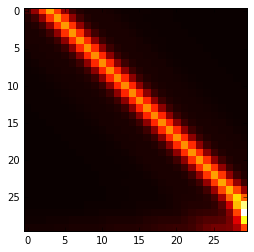

In [284]:
d3 = delta_op(3, 512)
aa = np.dot(np.dot(pe_30, d3), pe_30.T)
plt.imshow(softmax(aa / math.sqrt(512)), cmap='hot', interpolation='nearest')
plt.show()

Or focus attention ten words back:

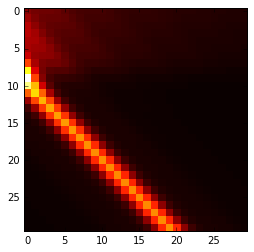

In [285]:
dm10 = delta_op(-10, 512)
aa = np.dot(np.dot(pe_30, dm10), pe_30.T)
plt.imshow(softmax(aa / math.sqrt(512)), cmap='hot', interpolation='nearest')
plt.show()

And we can smear attention around a window of, say, 5 words to the left through 5 words to the right:

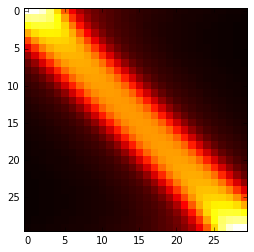

In [286]:
dpm5 = sum([delta_op(r, 512) for r in range(-5, 5 + 1)]) / 11
aa = np.dot(np.dot(pe_30, dpm5), pe_30.T)
plt.imshow(softmax(aa / math.sqrt(512)), cmap='hot', interpolation='nearest')
plt.show()

Or even do weird skpping operations, like looking at a five word window but ignoring the 3 words in the middle:

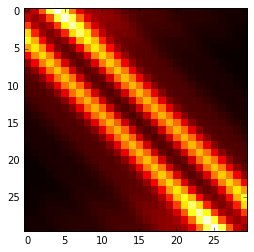

In [287]:
ddd = (dpm5 * 11 - sum([delta_op(r, 512) for r in range(-1, 1 + 1)]) * 2) / 8
aa = np.dot(np.dot(pe_30, ddd), pe_30.T)
plt.imshow(softmax(aa / math.sqrt(512)), cmap='hot', interpolation='nearest')
plt.show()

We can also attend to absolute positions, exploiting the relative constancy of the lowest frquency components.

In [265]:
def abs_op(pos, D):
    M = np.zeros((D, D))
    for i in range(D / 2):
        sin_beta = pe_sin(pos, i, D)
        cos_beta = pe_cos(pos, i, D)
        ii = 2 * i
        M[D - 1, ii] = sin_beta
        M[D - 1, ii + 1] = cos_beta
    return M

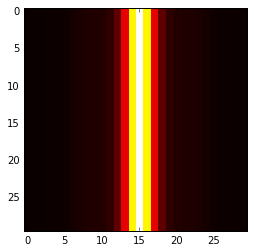

In [310]:
w1 = abs_op(15, 512)
aa = np.dot(np.dot(pe_30, w1), pe_30.T)
plt.imshow(softmax(aa / math.sqrt(512)), cmap='hot', interpolation='nearest')
plt.show()